In [156]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
UIMatrix = np.load('UIMatrix.npy')
UIMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [4, 0, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]])

用户矩阵P
商品矩阵Q
正则化系数$\lambda$
步长$\epsilon$
迭代公式：
$$
P_{u\times k} = (1-\epsilon \lambda)P + \epsilon E_{u\times i}Q^T \\
Q_{k\times i} = (1-\epsilon \lambda)Q + \epsilon P^TE_{u\times i}
$$

In [266]:
# 有正则化的矩阵分解
# 隐空间维度k
def mf_regular(X, loss):
    eps1 = 10
    eps2 = 1e-7
    max_iter = int(2e5)
    n,m = X.shape
    k = int(min(n, m)*0.01)  # 隐空间大小(试出来的)
    P = np.random.random((n, k))  # 初始化用户矩阵
    Q = np.random.random((k, m))  # 初始化商品矩阵
    lam = 0   # 正则化系数
    step = 5e-6  # 步长
    E = (X - P @ Q)  # 初始化
    lossi = 1
    for _ in range(max_iter):
        # 更新P,Q,E
        P = (1-step*lam)*P + step*E@Q.T
        Q = (1-step*lam)*Q + step*P.T@E
        E = (X - P @ Q)
        lossi_old = lossi
        lossi = 0.5*(np.linalg.norm(E)**2+lam*(np.linalg.norm(P)**2+np.linalg.norm(Q)**2))
        loss.append(lossi)
        if _%100==0:
            print(lossi)
        if np.abs(lossi-lossi_old) <= eps1:
            if np.abs(lossi-lossi_old) <= eps2:
                print('!')
                break
            elif step<=1e-9:
                pass
            else:
                print('step*0.9')
                step *= 0.9
                eps1 *= 0.5
    return P,Q

loss = []
P,Q = mf_regular(UIMatrix, loss)

6526720.54579978
639615.1794320245
614743.0577272653
603503.3873381302
598179.5492738971
595514.4752073663
594063.0728969678
step*0.9
593226.6336875682
592631.6152251018
step*0.9
592173.6922766356
591775.9835154013
591399.086688095
591030.9956760049
590665.0357072592
590297.3625959991
589925.6127950379
589548.170515324
589163.7654543119
588771.2471582037
588369.4531214577
587957.1258973565
587532.8550077867
587095.0304777467
586641.8007734431
586171.0311560471
585680.2602521384
585166.6536794656
584626.9542344535
584057.4286615654
583453.811513166
582811.2471554467
582124.2316420119
581386.5570096036
580591.261588348
579730.5911877302
578795.9775255556
577778.0419839183
576666.6346261728
575450.9202393038
574119.5247214255
572660.7560295806
571062.9136075513
569314.6980573912
567405.7280456674
565327.1633232669
563072.4208038866
560637.954945974
558024.055158258
555235.5937434608
552282.6414759152
549180.8588095774
545951.5737343595
542621.4761648817
539221.8944708706
535787.6692784008

KeyboardInterrupt: 

[517686.599595903, 517657.6154077746, 517628.6484393669, 517599.69870789436, 517570.766230517, 517541.85102433, 517512.9531063714, 517484.0724936185, 517455.20920298994, 517426.36325134506]
5967


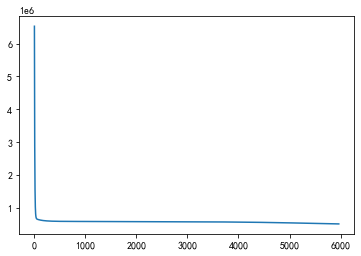

In [267]:
plt.plot(range(len(loss)),loss)
print(loss[-10:])
print(len(loss))
plt.show()

In [176]:
print(P@Q)

[[-0.61991081  0.1793468   0.96264556 ... -1.34211814  0.89204981
   0.06717406]
 [-0.19230269  0.99539924 -0.20764107 ... -0.02541934  1.02464682
   0.30612626]
 [-0.42005106  0.18727054  1.89311405 ... -0.31025125  0.17240051
   0.09722502]
 ...
 [ 0.91002061 -1.7593836  -0.30080322 ... -0.39946707 -0.2510317
  -0.48771645]
 [ 0.49788745  0.5814605   1.14731845 ... -0.53499646 -0.21744347
   0.51906512]
 [ 1.64852396  0.56388476  1.12563927 ...  2.11852197 -0.28534863
  -0.74723439]]
